In [2]:
import requests
import pandas as pd

In [3]:
GRT_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/volume-mainnet-test"
def grt_query(query):
    r = requests.post(GRT_ENDPOINT, json={'query': query})
    return r.json()['data']

In [4]:
GRT_POOL_QUERY = """
{pools(first: 1000) {
  name
  isV2
  id
}}"""
pools = grt_query(GRT_POOL_QUERY)['pools']

In [5]:
pools[0]

{'name': 'Curve.fi Factory USD Metapool: RC_bBADGER_5_DAI_2021_6_30',
 'isV2': False,
 'id': '0x0043fcb34e7470130fde28198571dee092c70bd7'}

In [19]:
GRT_SWAP_QUERY = """
{pool(id: "%s") {
  id
  swapEvents(first: 1000) {
  	buyer
    amountSoldUSD
    amountBoughtUSD
    timestamp
  }
}
}
"""

In [20]:
import concurrent.futures

queries = [GRT_SWAP_QUERY % pool['id'] for pool in pools]

with concurrent.futures.ThreadPoolExecutor() as executor: # In this case thread would be better
    results = executor.map(grt_query,queries)

In [21]:
results = list(results)

In [30]:
results[1]

{'pool': {'id': '0x01fe650ef2f8e2982295489ae6adc1413bf6011f',
  'swapEvents': [{'buyer': '0x97f31b64c9b4ce4ab96e6e550026b122485ee18e',
    'amountSoldUSD': '1935.973399109441861009696485903239',
    'amountBoughtUSD': '1935.204395375844550885229125338987',
    'timestamp': '1648443612'},
   {'buyer': '0xc771c0e0006ab4bd38e697893cbb37d800f81027',
    'amountSoldUSD': '31892.21349521686242862695221966514',
    'amountBoughtUSD': '31892.19874345344261336324762282936',
    'timestamp': '1648594067'},
   {'buyer': '0x1c5d4d16c8d809c3fbd9ecb86785b0315cc69359',
    'amountSoldUSD': '5795.526764775561068463550596935068',
    'amountBoughtUSD': '5795.526467483112957122982497069333',
    'timestamp': '1651638787'},
   {'buyer': '0xc4eb32c145a4965fb6150a295bf5750eb285b123',
    'amountSoldUSD': '62516.07308871133741550671905961996',
    'amountBoughtUSD': '62516.0374758177467019216902742921',
    'timestamp': '1649339981'},
   {'buyer': '0xc6033d4cb99cf08858bc1ab19ae3283c07090365',
    'amountSol

In [79]:
df = pd.DataFrame([{'pool': result['pool']['id']} | event for result in results for event in result['pool']['swapEvents']])
df

,pool,buyer,amountSoldUSD,amountBoughtUSD,timestamp
0,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1156.462792818217770213632145845818,1156.972907225342548345,1622720984
1,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,3282.297886475391170943976321851474,3282.056108423886254264,1622586311
2,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,8465.250366468469231337770147998399,8497.878254552045245019,1622519689
3,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,57272.15063092577379744151392792888,57273.51675837831579106,1622601370
4,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1071.526675437278290375,1068.220145590055428692,1622511272
...,...,...,...,...,...
92607,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,2189.429248938073016775352388563751,2202.431101320858537121875249897464,1627311357
92608,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,71319.50497530878551791964008080387,71740.182204653372699629,1625099676
92609,0xfe97d8f55884186e50aedba306ad553911a26a24,0x2d25461573c7de76e14654b7de49b046f7b77379,13003.15231675174989566459268387968,13033.966237,1627605453
92610,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,556.2058593777106616121392333048901,561.0250617407030456817117623494544,1625953375


In [80]:
df['volume'] = (df['amountSoldUSD'].astype(float) + df['amountBoughtUSD'].astype(float)) / 2
df.drop(['amountSoldUSD', 'amountBoughtUSD'], axis=1, inplace=True)
df

,pool,buyer,timestamp,volume
0,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1622720984,1156.717850
1,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1622586311,3282.176997
2,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1622519689,8481.564311
3,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1622601370,57272.833695
4,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1622511272,1069.873411
...,...,...,...,...
92607,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1627311357,2195.930175
92608,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1625099676,71529.843590
92609,0xfe97d8f55884186e50aedba306ad553911a26a24,0x2d25461573c7de76e14654b7de49b046f7b77379,1627605453,13018.559277
92610,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1625953375,558.615461


In [81]:
paraswap = ['0xdef171fe48cf0115b1d80b88dc8eab59176fee57',
                   '0x1bd435f3c054b6e901b7b108a0ab7617c808677b',
           '0xf90e98f3d8dce44632e5020abf2e122e0f99dfab']

zerox = [    '0xdef1c0ded9bec7f1a1670819833240f027b25eff',
    '0x22f9dcf4647084d6c31b2765f6910cd85c178c18',
        '0x561b94454b65614ae3db0897b74303f4acf7cc75']

oneinch = ['0x1111111254fb6c44bac0bed2854e76f90643097d',
    '0xfd3dfb524b2da40c8a6d703c62be36b5d8540626', 
    '0xc176761d388caf2f56cf03329d82e1e7c48ae09c', 
    '0x7c6ce24d013cd4ddf4c193ce318e3d5533a33f42', 
    '0x27239549dd40e1d60f5b80b0c4196923745b1fd2',
    '0xec193b3d86657ab0dcce9f33641cb7da6acefb0c',
    '0x220bda5c8994804ac96ebe4df184d25e5c2196d4',
    '0xe069cb01d06ba617bcdf789bf2ff0d5e5ca20c71',
    '0x0bf16c34b38648bb08deacf4dd4b239c44bb33c1'    
]

bots = [ '0xeef86c2e49e11345f1a693675df9a38f7d880c8f',
    '0xec001d0000004536cad29291f4000000d029abb2',
    '0xa1006d0051a35b0000f961a8000000009ea8d2db',
    '0x0000000000007f150bd6f54c40a34d7c3d5e9f56',
    '0x45716d9eddbc332df1d42b9f540fbebed671b20f',
    '0x1c073d5045b1abb6924d5f0f8b2f667b1653a4c3',
    '0x00000000c2cf7648c169b25ef1c217864bfa38cc',
        '0xb23dc3f00856288cd7b6bde5d06159f01b75aa4c',
        '0xa10fca31a2cb432c9ac976779dc947cfdb003ef0',
        '0x5f62593c70069abb35dfe2b63db969e8906609d6',
        '0x83a30b9c73de15560aa02a18964c45ad7a41d88e',
        '0x2057cfb9fd11837d61b294d514c5bd03e5e7189a',
        '0x000000000dfde7deaf24138722987c9a6991e2d4'
]

curve = ['0x81c46feca27b31f3adc2b91ee4be9717d1cd3dd7', 
         '0x2393c368c70b42f055a4932a3fbec2ac9c548011',
        '0x5d0f47b32fdd343bfa74ce221808e2abe4a53827',
        '0xfa9a30350048b2bf66865ee20363067c66f67e58']

aggregators = dict(zip(paraswap, ['Paraswap'] * len(paraswap))) | dict(zip(zerox, ['ZeroX'] * len(zerox))) | dict(zip(oneinch, ['1inch'] * len(oneinch))) | dict(zip(bots, ['Bots'] * len(bots))) | dict(zip(curve, ['Curve exchange'] * len(curve)))

aggregators['0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d'] = 'YieldFarming.insure'


In [82]:
df_chart = df.copy()
df_chart['buyer'] = df_chart['buyer'].apply(lambda x: aggregators[x] if x in aggregators else 'Other')

df['buyer'] = df['buyer'].apply(lambda x: aggregators[x] if x in aggregators else x)

In [83]:
df['buyer'].value_counts()[:20]

Bots                                          22137
1inch                                          9216
Curve exchange                                 3960
Paraswap                                       3596
ZeroX                                          3070
YieldFarming.insure                            1112
0x3b15cec2d922ab0ef74688bcc1056461049f89cb      619
0xdb38ae75c5f44276803345f7f02e95a0aeef5944      591
0xf2f400c138f9fb900576263af0bc7fcde2b1b8a8      582
0x0000006daea1723962647b7e189d311d757fb793      476
0x92498f5a2878a2d7d6f29ccdba5b52273b29a2d9      459
0xc5fa220347375ac4f91f9e4a4aab362f22801504      426
0x2af33e93f68b8497bb535c492f5867c7e83f2bc4      419
0xd1602f68cc7c4c7b59d686243ea35a9c73b0c6a2      335
0x07197a25bf7297c2c41dd09a79160d05b6232bcf      324
0xdf388f1155e621e21764988289def81da92f3284      323
0x4d638adb8c07a78655e9ae88641c4202774e6584      322
0xe07025d4ce7881b7f50d4d6b954e43590dcb1092      305
0xf6d78d9c50ffbc2917e374fd185b8ff89c55effc      304
0x73ab2bd10a

In [84]:
WEEK = 3600 * 24 * 7
df_chart['timestamp'] = df_chart['timestamp'].apply(lambda x: ((int(x) // WEEK) * WEEK))
df_chart['timestamp'] = pd.to_datetime(df_chart['timestamp'],unit='s')

volume
timestamp  buyer                       
2020-10-29 Bots            5.719292e+04
           Other           2.937353e+07
           ZeroX           4.258549e+05
2020-11-05 Bots            8.469402e+04
           Other           6.467030e+07
...                                 ...
2022-07-21 Bots            5.036897e+05
           Curve exchange  1.376789e+05
           Other           2.691220e+06
           Paraswap        2.538687e+04
           ZeroX           3.145345e+05

[517 rows x 1 columns]

In [86]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [88]:
df_chart.groupby(['timestamp', 'buyer']).sum()

volume
timestamp  buyer                     
2020-10-29 Bots              57192.92
           Other          29373532.87
           ZeroX            425854.88
2020-11-05 Bots              84694.02
           Other          64670303.04
...                               ...
2022-07-21 Bots             503689.70
           Curve exchange   137678.89
           Other           2691220.12
           Paraswap          25386.87
           ZeroX            314534.52

[517 rows x 1 columns]

In [89]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [92]:
chart_data = df_chart.pivot_table('volume', ['timestamp'], 'buyer').fillna(0)

In [97]:
chart_data

buyer,1inch,Bots,Curve exchange,Other,Paraswap,YieldFarming.insure,ZeroX
timestamp,,,,,,,
2020-10-29,0.00,9532.15,0.00,87944.71,0.00,0.00,42585.49
2020-11-05,0.00,7057.83,0.00,127554.84,0.00,0.00,136441.27
2020-11-12,0.00,14709.59,0.00,140099.20,0.00,0.00,56460.29
2020-11-19,0.00,8188.09,0.00,143103.60,0.00,0.00,26668.52
2020-11-26,0.00,49895.63,0.00,160059.59,0.00,0.00,69711.11
...,...,...,...,...,...,...,...
2022-06-23,234740.53,19877.18,140849.37,60773.05,17464.53,0.00,101267.02
2022-06-30,163151.44,24800.48,18959.33,61583.19,33304.78,0.00,86924.29
2022-07-07,26418.52,13714.47,17950.11,51834.50,17899.29,0.00,129024.35


In [101]:
import matplotlib.dates as mdates  
import numpy as np

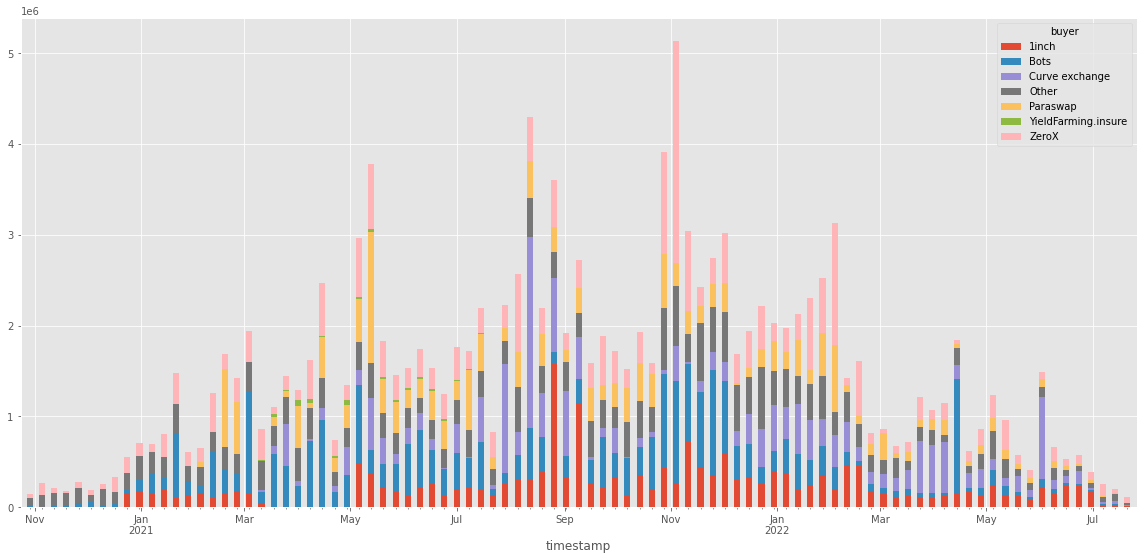

In [110]:
ax = chart_data.plot.bar(stacked=True, figsize=(20,10))

bar_width_md_default, = np.diff(mdates.date2num(chart_data.index[:2]))/2
bar_width = ax.patches[0].get_width()
bar_width_md = bar_width*bar_width_md_default/0.5
x_bars_md = mdates.date2num(chart_data.index) - bar_width_md/2
nvar = len(ax.get_legend_handles_labels()[1])
x_patches_md = np.ravel(nvar*[x_bars_md])
for patch, x_md in zip(ax.patches, x_patches_md):
    patch.set_x(x_md)
    patch.set_width(bar_width_md)
maj_loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(maj_loc)
ax.set_xticks(x_bars_md + bar_width_md/2, minor=True)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
ax.xaxis.set_major_formatter(fmt)
xmin = min(x_bars_md) - bar_width_md
xmax = max(x_bars_md) + 2*bar_width_md
ax.set_xlim(xmin, xmax)
ax.figure.autofmt_xdate(rotation=0, ha='center')

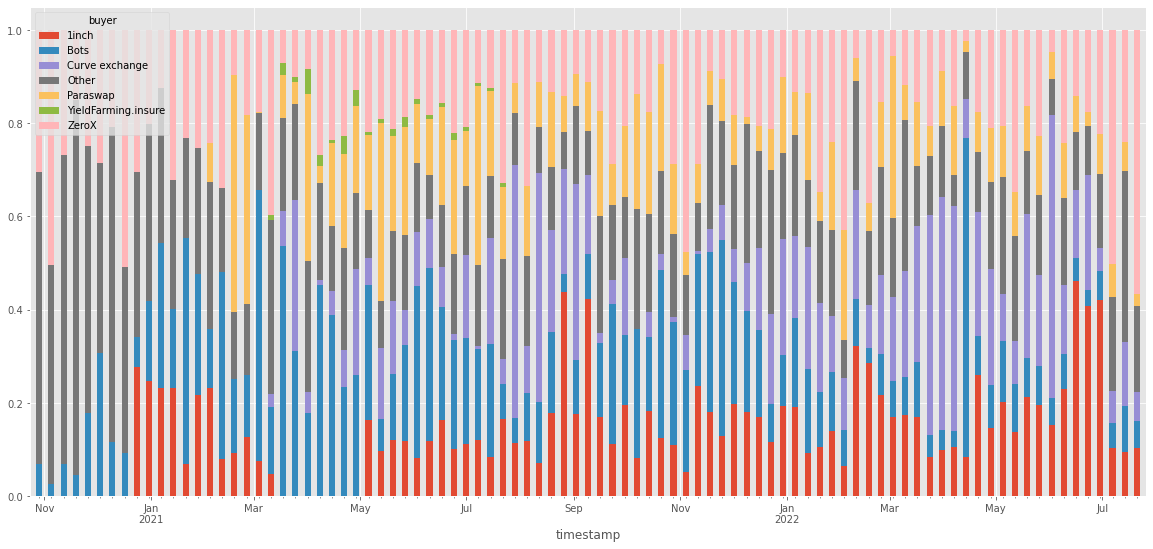

In [107]:
ax = chart_data.divide(chart_data.sum(axis=1), axis=0).plot.bar(stacked=True, figsize=(20,10))

bar_width_md_default, = np.diff(mdates.date2num(chart_data.index[:2]))/2
bar_width = ax.patches[0].get_width()
bar_width_md = bar_width*bar_width_md_default/0.5
x_bars_md = mdates.date2num(chart_data.index) - bar_width_md/2
nvar = len(ax.get_legend_handles_labels()[1])
x_patches_md = np.ravel(nvar*[x_bars_md])
for patch, x_md in zip(ax.patches, x_patches_md):
    patch.set_x(x_md)
    patch.set_width(bar_width_md)
maj_loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(maj_loc)
ax.set_xticks(x_bars_md + bar_width_md/2, minor=True)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
ax.xaxis.set_major_formatter(fmt)
xmin = min(x_bars_md) - bar_width_md
xmax = max(x_bars_md) + 2*bar_width_md
ax.set_xlim(xmin, xmax)
ax.figure.autofmt_xdate(rotation=0, ha='center')